# Stocks to Use vs Price

#### *The Python packages used in this notebook are listed in the requirements.txt file located in the current directory. The packages can be installed by simply running 'pip install --requirement requirements.txt' on your command line. Adjustments may be needed if you are not using the same versions included in the requirements file.*

This sample Gro API script creates a basic price valuation model for corn and soybeans during the growing season using the US stocks-to-use ratio. A stocks-to-use ratio is calculated by dividing projected ending stocks by projected total crop usage (domestic consumption + exports) for a given marketing year. A stocks-to-use ratio is a normalized inventory measurement, and, therefore, is a helpful tool for analysis over different time periods and of different crops.

According to the basic principles of economics, a commodity's stocks-to-use ratio should, theoretically, have an inverse relationship its price. When less inventory is available to cover a given amount of demand, prices should rise to encourage the creation of additional supplies and destroy the marginal unit of demand. Conversely, when inventories are too high, prices should fall to encourage new demand and remove unprofitable supply from the market. In this script, we examine the economic theory in practice, calculating a 'fair value' price estimate based on the historical relationship between the stocks-to-use ratio and prices. 

The inventory and demand forecasts that compose the stocks-to-use ratio are updated each month based on data from the USDA's [PS&D](https://app.gro-intelligence.com/dictionary/sources/14) (Production, Supply, and Distribution) report. The PS&D is the market standard for global agricultural forecasts and is incorporated into the USDA's flagship WASDE report. For the price variable, we use a monthly average price of the [Chicago Mercantile Exchange](https://app.gro-intelligence.com/dictionary/sources/81) (CME) futures contract that is most actively traded: December futures for corn and November futures for soybeans.

The output will be a PDF file for each modeled crop, saved in the current working directory. The PDFs will have 7 (soybeans) or 8 (corn) pages in total, including a scatterplot for each report month during the growing season, as well as a scatterplot summarizing the entire sample. For example, the corn-June scatterplot will compare the US stocks-to-use ratio from all June PS&D reports compared to the monthly average December corn futures price in June.

Follow this [link](https://app.gro-intelligence.com/displays/gK9p5kadE) to a Gro public display containing data series used in this exercise.

## Preliminary
First, we import all the Python packages needed to run this notebook. We then create a GroClient object and define Gro entity ids to save for future use. We will use these throughout the notebook to simplify the retrieval, storage, and manipulation of data. We also create a Python dictionary defining the preferred futures contract month for each crop.

In [1]:

import os
import calendar
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model

from api.client.gro_client import GroClient

API_HOST = 'api.gro-intelligence.com'
TOKEN    = os.environ['GROAPI_TOKEN']
client   = GroClient(API_HOST, TOKEN)

# define region
UNITED_STATES_REGION_ID = client.search_for_entity('regions', 'United States of America')

# define metrics
SETTLEMENT_PRICE_METRIC_ID = client.search_for_entity('metrics', 'futures prices settle (currency/mass)')
ENDING_STOCKS_METRIC_ID = client.search_for_entity('metrics', 'stocks, ending quantity (mass)') 
CONSUMPTION_METRIC_ID = client.search_for_entity('metrics', 'domestic consumption (mass)')
EXPORT_METRIC_ID = client.search_for_entity('metrics', 'export volume (mass)')

# define sources
CME = client.search_for_entity('sources', 'CME')
PSD = client.search_for_entity('sources', 'PS&D')

crop_dictionary = {'corn':{'futures_contract_month':12},
                   'soybeans':{'futures_contract_month':11}}

## Define Data Functions

In these functions, we standardize and organize our data. First, we create a rolling futures price series, which includes a single price for each trading day over the full history of CME/CBOT trading.

In [2]:
def contract_month_history(crop, contract_month):
    """full history of settlement prices for a specific commodity
    and month of expiry. e.g. December corn

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'
    contract_month : integer

    Returns
    -------
    pandas.Dataframe
    """
    market = client.search_for_entity('items', crop) 
    
    client.add_single_data_series({'metric_id': SETTLEMENT_PRICE_METRIC_ID, 
                                   'item_id': market, 
                                   'region_id': UNITED_STATES_REGION_ID, 
                                   'source_id': CME,
                                   'start_date': '2006-01-01',
                                   'show_revisions': True})
    
    df = client.get_df().sort_values(['end_date'])
    
    market_df = df.loc[(df.item_id == market) & (df.metric_id == SETTLEMENT_PRICE_METRIC_ID)]
    price_df  = market_df.loc[market_df['end_date'].dt.month == contract_month].groupby(\
                ['reporting_date']).first()[['value', 'end_date']]

    return price_df

The following get_price function first identifies the proper futures contract month to use in the price model. In this case, the most actively traded contract: December futures for corn and November futures for soybeans. We then take monthly average of the daily price series returned from the contract_month_history function.

In [3]:
def get_price(crop):
    """calculates monthly average new crop CME price    

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'
    
    Returns
    -------
    pandas.Series
    """  
    contract_month = crop_dictionary[crop.lower()]['futures_contract_month']
    
    price_history = contract_month_history(crop, contract_month)
    
    price = price_history['value'].resample('M').mean().resample('D').fillna('bfill')
    price.name = 'price'
    
    return price

The next function calculates the annual stocks-to-use ratio for a given crop. Note that 'show_revisions' is set to True when the series is added to GroClient. This allows us to use the forecasted stocks-to-use ratio from each monthly PS&D report. For this exercise, we use stocks and demand estimates for the most forward-looking crop year available.

In [4]:
def get_stocks_to_use(crop, region=UNITED_STATES_REGION_ID):
    """Calculate historical carryout to use ratio for a given commodity  

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'
    Returns
    -------
    pandas.Series
    """
    crop_id = client.search_for_entity('items', crop)
    tonne_unit_id = 8 
    
    # add stocks series
    client.add_single_data_series({'metric_id': ENDING_STOCKS_METRIC_ID, 
                                   'item_id': crop_id, 
                                   'region_id': region, 
                                   'source_id': PSD, 
                                   'frequency_id': 9,
                                   'unit_id': tonne_unit_id,
                                   'start_date': '2006-12-31',
                                   'show_revisions': True})
    
    # add consumption series
    client.add_single_data_series({'metric_id': CONSUMPTION_METRIC_ID, 
                                    'item_id': crop_id, 
                                    'region_id': region, 
                                    'source_id': PSD, 
                                    'frequency_id': 9,
                                    'unit_id': tonne_unit_id,
                                    'start_date': '2006-12-31',
                                    'show_revisions': True})
    # add exports series
    client.add_single_data_series({'metric_id': EXPORT_METRIC_ID, 
                                    'item_id': crop_id, 
                                    'region_id': region, 
                                    'source_id': PSD, 
                                    'frequency_id': 9,
                                    'unit_id': tonne_unit_id,
                                    'start_date': '2006-12-31',
                                    'show_revisions': True})
    
    df = client.get_df()
    df = df.sort_values('end_date', ascending=True)
    df_grp = df.groupby(['item_id', 'metric_id', 'reporting_date']).last()
    
    stocks      = df_grp.loc[(crop_id, ENDING_STOCKS_METRIC_ID), :]['value']
    consumption = df_grp.loc[(crop_id, CONSUMPTION_METRIC_ID), :]['value']
    exports     = df_grp.loc[(crop_id, EXPORT_METRIC_ID), :]['value']
    
    total_use = consumption.add(exports)
    
    stocks_to_use = stocks.div(total_use)
    stocks_to_use.name = 'stocks_to_use'
    
    return stocks_to_use

## Define Analysis and Charting Functions
In the first function, we run a simple linear regression model on a pandas dataframe with columns of price and stocks-to-use ratio. The second function creates a scatterplot between the two variables. 

In [5]:
def run_regression(df_in):
    """run linear regression between stocks to use ratio and price  

    Parameters
    ----------
    df : pandas.DataFrame

    Returns
    -------
    float, float, float
        r-squared value, intercept, and x variable coefficient
    """
    regression_model = linear_model.LinearRegression()
    stocks_to_use    = df_in[['stocks_to_use']]
    price            = df_in['price']
    
    regression_model.fit(stocks_to_use, price)
    
    r_squared = regression_model.score(stocks_to_use, price)
    
    return r_squared, regression_model.intercept_, regression_model.coef_[0]

The next function creates a scatterplot with price on the y-axis and the stocks-to-use ratio on the x-axis. 

In [6]:
def create_scatterplot(df_in, month_name, crop):
    """scatterplot vizualization for regression model

    Parameters
    ----------
    df_in : string
        'corn' or 'soybeans'
    month_name : int or string
        month of report being analyzed or 'all' for all months
    crop : string
        'corn' or 'soybeans'
    """    
    r_squared, intercept, slope = run_regression(df_in)
    
    fig = plt.figure(figsize=(5, 5), dpi=100)
    ax  = fig.add_subplot(111)

    line = slope * df_in.stocks_to_use.values + intercept
    
    if (isinstance(month_name, str) == False):
        month_name = calendar.month_abbr[month_name]
    
    fig_title = '{}: {} Reports: rsq:{}'.format(crop.title(), month_name, r_squared.round(2))
    
    fig_label = 'y={:.2f}x+{:.2f}'.format(slope, intercept)
    plt.plot(df_in.stocks_to_use.values, line, 'r', label=fig_label)

    plt.scatter(df_in.stocks_to_use.values, df_in.price.values, color="k", s=3.5)
    plt.legend(fontsize=9)

    fig.suptitle(fig_title, fontsize=12)
    ax.set_xlabel('Stocks to Use Ratio')
    ax.set_ylabel('Price')

    return fig

## Create PDF File of Scatterplots

Next, we run the code for corn and soybeans, and output the results to PDFs. We also print the scatterplots directly in the notebook for users who prefer to see the results in this format. Running the following section of code will require approximately 100,000 data points (~50,000 points for each crop run).

Added {'metric_id': 1470032, 'item_id': 274, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'unit_id': 8, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 1480032, 'item_id': 274, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'unit_id': 8, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 20032, 'item_id': 274, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'unit_id': 8, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 15820065, 'item_id': 274, 'region_id': 1215, 'source_id': 81, 'start_date': '2006-01-01', 'show_revisions': True}
Added {'metric_id': 1470032, 'item_id': 270, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'unit_id': 8, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 1480032, 'item_id': 270, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'unit_id': 8, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 20032, 'item_id': 

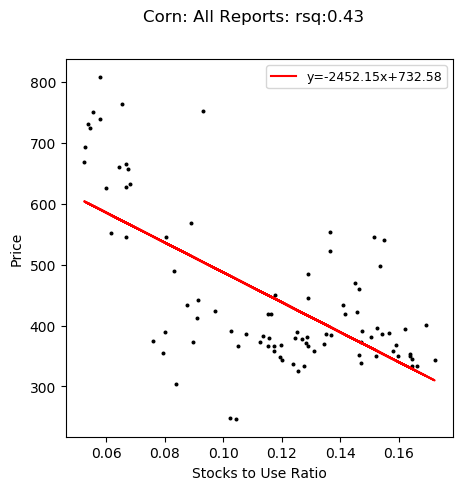

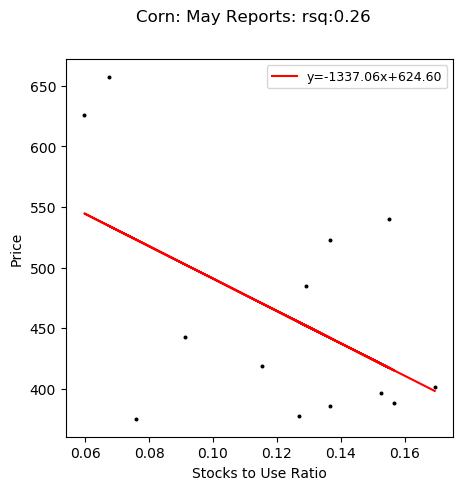

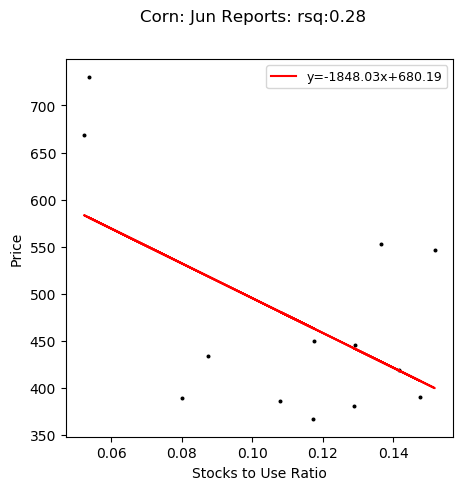

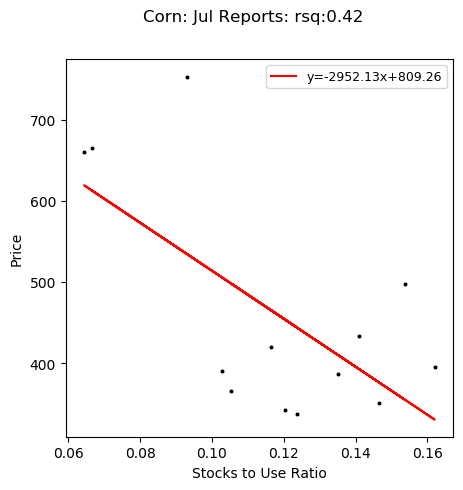

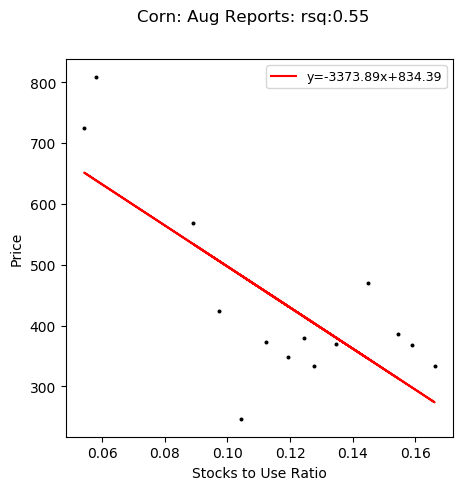

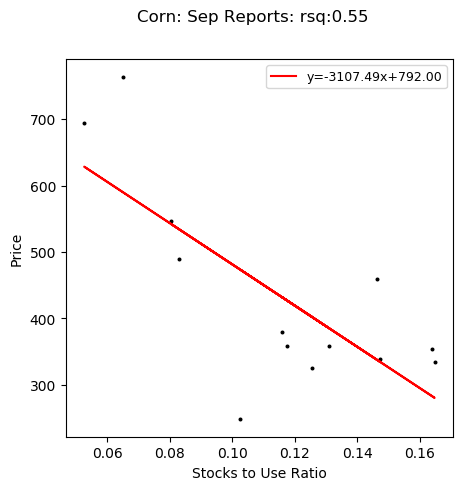

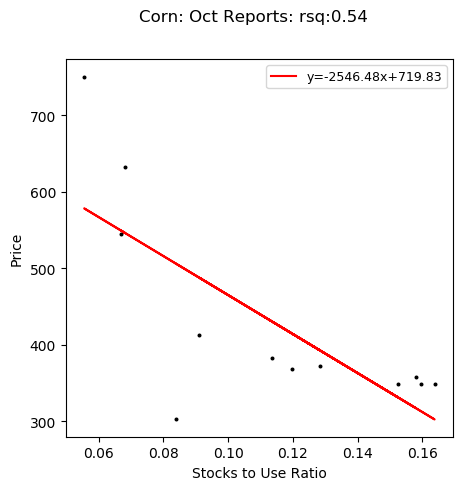

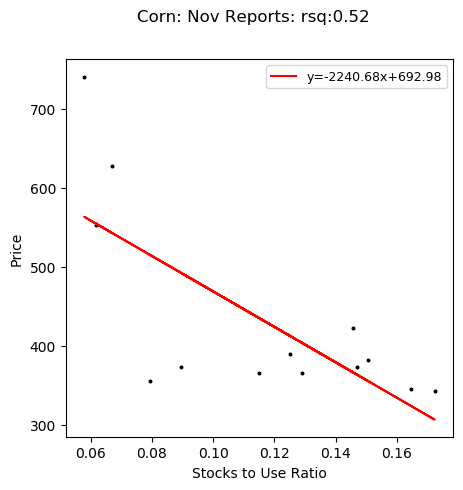

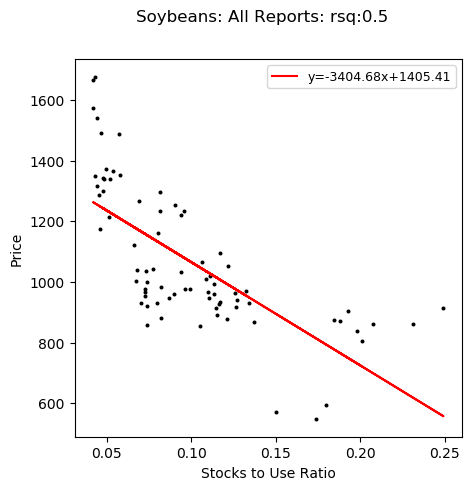

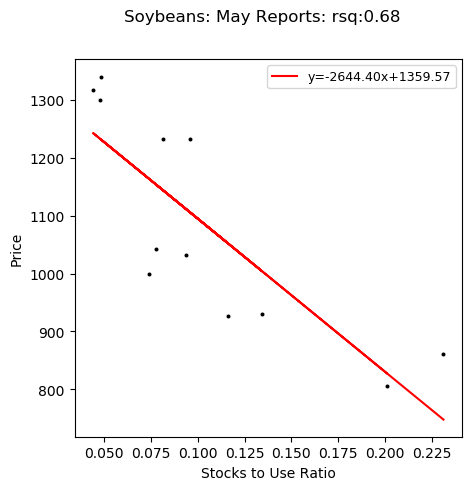

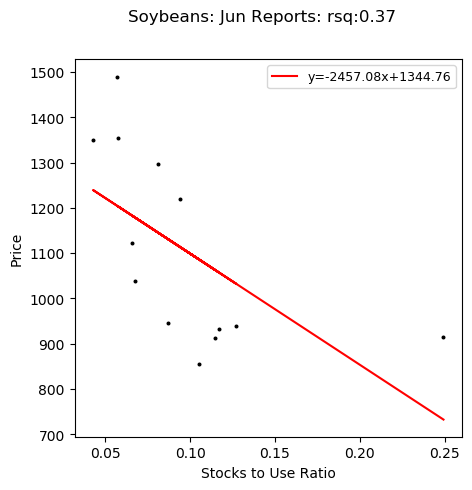

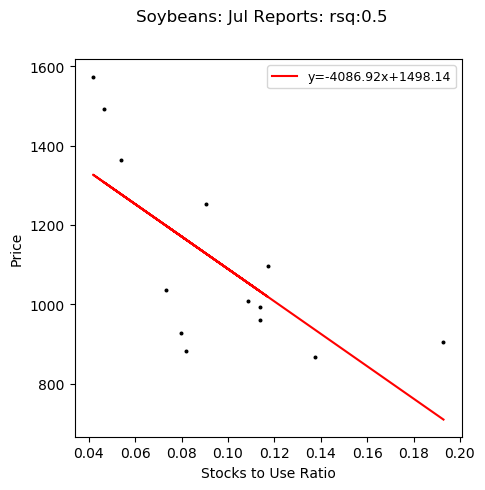

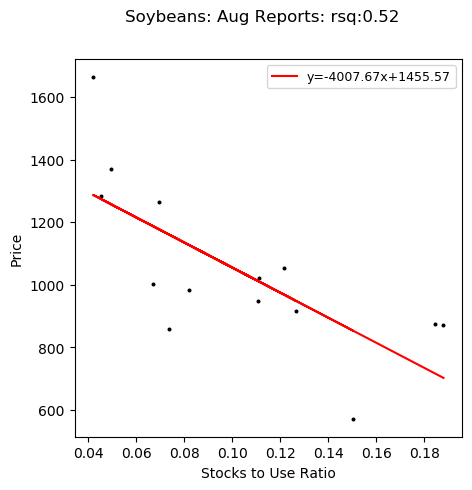

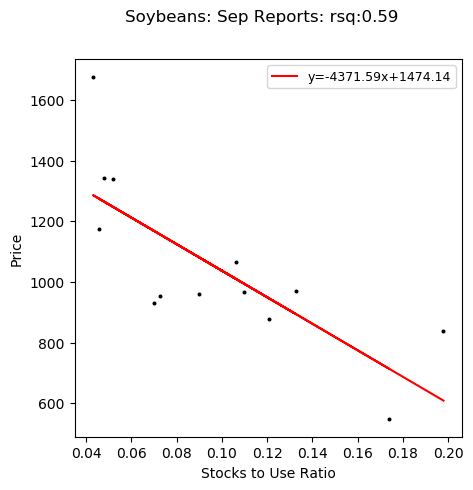

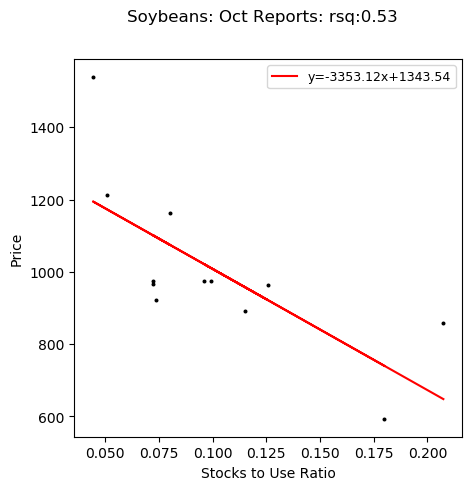

In [7]:
def write_price_model(crop):
    """run a regression between price and stocks to use for all WASDE report months,
       create a scatterplot of regression values, and write to PDF

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'

    """
    stocks_to_use = get_stocks_to_use(crop)
    price         = get_price(crop)
    
    model_input_df = pd.concat([stocks_to_use, price], axis=1).dropna()
    
    # remove months when PS&D forecasts do not cover the current crop year
    months_to_test = range(5, crop_dictionary[crop]['futures_contract_month'])
    model_input_df = model_input_df[model_input_df.index.month.isin(months_to_test)]
    
    month_groups = model_input_df.groupby(model_input_df.index.month)
        
    fig_list = [create_scatterplot(model_input_df, 'All', crop)]
    fig_list.extend([create_scatterplot(group, name, crop) for name, group in month_groups])

    filename = os.path.join(os.getcwd(), '{}.pdf'.format(crop))
    pdf_page = PdfPages(filename)
    for f in fig_list: pdf_page.savefig(f)
    pdf_page.close()
    

write_price_model('corn')
write_price_model('soybeans')

## Conclusion
The charts in this analysis can be used as a basic seasonal price valuation tool for the corn and soybean markets. Users can determine if current futures prices are overvalued or undervalued based on the regression equations, and get a sense of the historical price range traded for each market given the current fundamental outlook.